# Religion

- Data Cleaning
- Data Visualisation
- Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
from datetime import datetime
from datetime import timezone
from SPARQLWrapper import SPARQLWrapper, JSON

%matplotlib inline

In [2]:
# Reading the data from religion revisions
# Contains the revisions for all the selected items
revisions = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data_with_revisions/religion_revisions.csv')
items = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/topics/data/religion.csv')

In [7]:
print("Number of Revisions in Religion Dataset")
print(revisions.shape)
print("Number of Wikidata Items in Religion Dataset")
print(items.shape)

Number of Revisions in Religion Dataset
(32969, 12)
Number of Wikidata Items in Religion Dataset
(13208, 3)


# Data Cleaning

- Drop uneccessary columns
- Assign types for all edits
- Assign user types for all edits
- Remove rows with empty comments - better to remove after calculating the types in case there are some edge cases which have not been discovered
- Convert timestamps to datetime objects
- (Remove items that contain only bot edits)
- Remove items with editcounts < (If removing rows with empty comments will need to recalculate the edit count and merge with dataset)

In [8]:
# Dropping unecessary columns from the revisions dataframe
rev = revisions.drop(['pageid', 'type', 'editentity', 'parentid'], axis=1)

In [10]:
# Method to assign edit types to each revision by using the comment
def get_edit_type(comment):
    # Decoding the comment from a bytes object to a string
    # Converting the comment to lowercase
    # c = comment.decode("utf-8").lower()
    c = comment.lower()
    # print(c)
    editType = '' 
    
    if c == '':
        return editType
    
    if "|" in c:
        # Comments which have |
        cc = c.split("|")[0].replace("/* ", "")
        if 'undo' in cc:
            editType = 'undo'
            return editType
        elif 'restore' in cc:
            editType = 'restore'
            return editType
        elif 'wbsetclaimvalue' in cc:
            editType = 'set'
            return editType
        elif 'wbsetlabeldescriptionaliases' in cc:
            editType = 'set'
            return editType
        elif 'wbcreateredirect' in cc:
            editType = 'create'
            return editType
        elif 'merge' in cc:
            editType = 'merge'
            return editType
        elif '-' in cc:
            ccc = cc.split("-")[1]
            if 'create' in ccc:
                editType = 'create'
                return editType
            elif 'add' in ccc:
                editType = 'add'
                return editType
            elif 'set' in ccc:
                editType = 'set'
                return editType
            elif 'update' in ccc:
                editType = 'update'
                return editType
            elif 'remove' in ccc:
                editType = 'remove'
                return editType
    if 'revert' in c: 
        editType = 'revert'
        return editType  
    elif 'protect' in c:
        editType = 'protect'
        return editType  
    elif 'undid' in c:
        editType = 'undo'
        return editType      
    return editType
        

In [11]:
# Assigning edit types to each revision
rev['type'] = [get_edit_type(comment) for comment in rev['comment']]

In [13]:
rev.shape

(32969, 9)

In [14]:
# Removing revisions with empty types 
# Removing revisions that either had an empty comment or or an edge case
to_remove = rev[rev['type'] == ''].index
rev = rev.drop(to_remove)

In [16]:
# Reading csv with bot names scraped from Wikidata
bots = pd.read_csv('/Users/tushi/PRJ/WikidataParsing/wikidata_bots.csv')

In [17]:
# Method to assign user types to revisions
# 3 types: Registered, Anonymous, Bot
def get_user_type(user):
    
    u = user[1:].replace("'", "")
    
    userType = ''
    
    if u == "":
        userType = 'Anonymous'
        return userType
    elif u in bots.values:
        userType = 'Bot'
        return userType
    else: 
        userType = 'Registered'
        return userType
    return userType
    

In [18]:
# Assigning user types to revisions
rev['usertype'] = [get_user_type(user) for user in rev['username']]

In [20]:
# Need to recalculate editcount for the items
# Drop old editcount column
rev = rev.drop(['editscount'], axis=1)

In [21]:
editscount = rev['qid'].value_counts()

In [22]:
editscount.describe()

count    13158.000000
mean         2.491412
std          3.256492
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        126.000000
Name: qid, dtype: float64

Rationale for Removing edits <= 5

- Research
- Range of edits is very large
- Median value that is the 50th percentile is 2 edits that is more than half the dataset has items that would not be very interesting to the research as we are interested in highly edited items
- Items in the 75th percentile have an editcount of 3 showing that only a small percentage of items - slightly greater than 25% of the items are those that can be deemed interesting
- Also important to note that given these values, the data could also contain a reasonable number of outliers - items which are highly edited but do not add value to the research - for example they do not contain reverts or they are sandbox items

In [23]:
# Converting to a dataframe so that it can be compared/merged with original dataframe
df_editscount = pd.DataFrame({'qid':editscount.index, 'editscount':editscount.values})

In [24]:
print('Items with No of Edits = 1')
print(len(df_editscount[df_editscount['editscount'] == 1]))

print('Items with No of Edits = 2')
print(len(df_editscount[df_editscount['editscount'] == 2]))

print('Items with No of Edits = 3')
print(len(df_editscount[df_editscount['editscount'] == 3]))

print('Items with No of Edits = 4')
print(len(df_editscount[df_editscount['editscount'] == 4]))

print('Items with No of Edits = 5')
print(len(df_editscount[df_editscount['editscount'] == 5]))

print('Items with No of Edits <= 5')
print(len(df_editscount[df_editscount['editscount'] <= 5]))

Items with No of Edits = 1
6102
Items with No of Edits = 2
3315
Items with No of Edits = 3
1191
Items with No of Edits = 4
1424
Items with No of Edits = 5
317
Items with No of Edits <= 5
12349


In [25]:
# If I am understanding correctly more than half the dataset has items with edits <= 5

In [26]:
# Removing items with editscount <= 5 
to_remove = df_editscount[df_editscount['editscount'] <= 5].index
df_editscount = df_editscount.drop(to_remove)

In [27]:
df_editscount.shape

(809, 2)

In [28]:
# Removing all items with editscount <= 5 from revisions dataset
# Removing by finding intersection on qid between bot sets
rev = pd.merge(rev, df_editscount, how='inner', on=['qid'])

In [30]:
# Converting the timestamps to datetime object
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

# Converting to datetime leaves the dates in form '2016-10-12 14:37:53+00:00'
# Formatting timestamp to remove +00:00
rev['timestamp'] = rev['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# strftime() returns a string object
# Converting back to datetime
rev['timestamp'] = pd.to_datetime(rev.timestamp, format='%Y-%m-%d %H:%M:%S')

In [31]:
# To query info based on datetime remember to input dates in complete formatting
# rev[rev['timestamp'] >= '2016-10-01 00:00:00']

Imp to parse timestamps as you would potentially be interested in looking at the time difference between edits in the future, difference between datetime objects can be found using timedelta from datetime.

In [33]:
rev.dtypes

Unnamed: 0             int64
qid                   object
revisionid           float64
timestamp     datetime64[ns]
comment               object
userid               float64
username              object
type                  object
usertype              object
editscount             int64
dtype: object

In [34]:
# Sparql Query to get labels using Qids
def get_item_label(qid):
    try:        
        # Specifying the Wikidata SPARQL endpoint
        sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
        
        # Query to access the label for the wikidata item
        sparql.setQuery('PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> SELECT ?label WHERE {wd:' + qid + ' rdfs:label ?label . SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } } LIMIT 1')
        
        # Converting result to JSON format
        sparql.setReturnFormat(JSON)
        result = sparql.query().convert()
        
        # result is in the form of "bindings" which are a list of dictionaries
        # Accessing the value of the label 
        itemLabel = result["results"]["bindings"][0]["label"]["value"]
        
        return itemLabel
    except Exception as ex:
        print(ex)
        return('')

In [38]:
print(df_editscount.head())
# Discovered wikipedia and wikidata and a template
print(get_item_label('Q52'))
print(get_item_label('Q2013'))
print(get_item_label('Q17517429'))

         qid  editscount
0        Q52         126
1      Q2013          91
2  Q17517429          68
3    Q365138          54
4  Q27611973          45
Wikipedia
ويكي معلومة
Template:Nobr


In [43]:
# Removing sandbox item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q52'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q52'].index
rev = rev.drop(to_remove_from_rev)

In [44]:
# Removing sandbox item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q2013'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q2013'].index
rev = rev.drop(to_remove_from_rev)

In [45]:
# Removing sandbox item from editscount and rev
to_remove = df_editscount[df_editscount['qid'] == 'Q17517429'].index
df_editscount = df_editscount.drop(to_remove)
# Removing item from dataset of revisions
to_remove_from_rev = rev[rev['qid'] == 'Q17517429'].index
rev = rev.drop(to_remove_from_rev)

In [46]:
print(df_editscount.head())
print(rev[rev['qid'] == 'Q52'])
print(rev[rev['qid'] == 'Q2013'])
print(rev[rev['qid'] == 'Q17517429'])

         qid  editscount
3    Q365138          54
4  Q27611973          45
5  Q27913349          44
6  Q27918436          41
7  Q27670150          39
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, qid, revisionid, timestamp, comment, userid, username, type, usertype, editscount]
Index: []


# Descriptive Statistics

In [47]:
rev['editscount'].describe().astype(int)

count    8911
mean       14
std         8
min         6
25%         8
50%        12
75%        20
max        54
Name: editscount, dtype: int32

In [48]:
rev['type'].describe()

count       8911
unique        10
top       create
freq        3284
Name: type, dtype: object

In [49]:
religion_items = rev['qid'].value_counts()

In [50]:
# converting a series to a dataframe
r_items = pd.DataFrame({'type':religion_items.index, 'count':religion_items.values})

In [52]:
# Items between the median and 75th percentile
r_items[(r_items['count'] >= 12) & (r_items['count'] <= 20)]

,type,count
89,Q27581431,20
90,Q2758090,20
91,Q27700022,20
92,Q27310330,20
93,Q7114536,20
...,...,...
233,Q3719780,12
234,Q15763734,12
235,Q60995,12
236,Q34726,12


# Statistics for Proxies

In [53]:
# Counting the value of the number of proxies that exist in the dataset
type_stats = rev['type'].value_counts()

In [54]:
# Converting a series to a Dataframe
type_s = pd.DataFrame({'type':type_stats.index, 'count':type_stats.values})
ts = type_s.set_index('type')
print(ts)

         count
type          
create    3284
add       3028
update     961
remove     710
set        645
merge      110
revert      85
undo        56
restore     31
protect      1


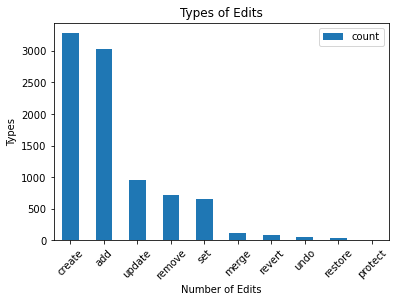

In [55]:
# Plotting the statistics for the proxies/types of edits in the data
ax = ts.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

plt.show()

In [56]:
# Since the total items are so less the values are much more comparable

In [57]:
# Extracting select proxies: remove, restore, revert, merge, undo, protect
controversial_proxies = ts.iloc[[3, 5, 6, 7, 8, 9]]
# print(controversial_proxies)

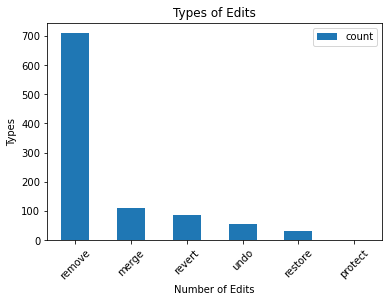

In [58]:
# Plotting select proxies
ax = controversial_proxies.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

In [59]:
# Extracting select proxies: restore, revert, merge, undo, protect
controversial_proxies_without_remove = ts.iloc[[5, 6, 7, 8, 9]]
print(controversial_proxies_without_remove)

         count
type          
merge      110
revert      85
undo        56
restore     31
protect      1


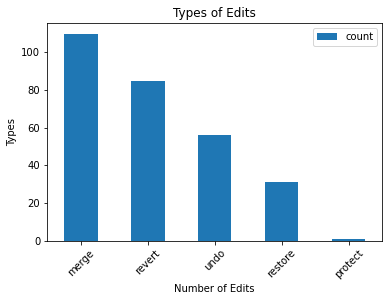

In [60]:
# Plotting select proxies without remove
ax = controversial_proxies_without_remove.plot.bar()

plt.title('Types of Edits')
plt.xlabel('Number of Edits')
plt.ylabel('Types')

plt.xticks(rotation=45)

# ax.invert_yaxis()

plt.show()

Why is merge the greatest? Why did countries and politics have undo as the greates?

# Statistics for No of Edits

In [61]:
no_of_edits = religion_items.to_numpy()

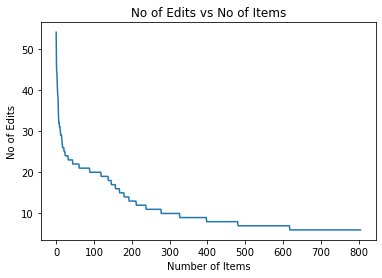

In [62]:
# Plotting No of Edits for the Items in the dataset 
# Line Plot

plt.plot(no_of_edits)

plt.title("No of Edits vs No of Items")
plt.xlabel("Number of Items")
plt.ylabel("No of Edits")

plt.show()

In [63]:
# Would be nice to have the bar chart I was thinking of
# with the number of items present in each of the ranges for edits

In [64]:
# Top 25% of the dataset

# Grouping by Proxies

In [65]:
reverts = rev["type"].str.contains("revert")
revert_edits = reverts.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [66]:
merges = rev["type"].str.contains("merge")
merge_edits = merges.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [67]:
undos = rev["type"].str.contains("undo")
undo_edits = undos.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [68]:
restores = rev["type"].str.contains("restore")
restore_edits = restores.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [69]:
protects = rev["type"].str.contains("protect")
protect_edits = protects.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [70]:
removes = rev["type"].str.contains("remove")
remove_edits = removes.groupby(rev["qid"], sort=False).sum().astype(np.uintc)

In [71]:
# Creating a dataframe which will contain qids for items and no of each proxy
proxies = pd.DataFrame({'revert': revert_edits, 'merge': merge_edits, 'undo': undo_edits, 'restore': restore_edits, 
                        'protect': protect_edits, 'remove': remove_edits})

In [72]:
proxies = proxies.reset_index()

In [73]:
proxies.columns

Index(['qid', 'revert', 'merge', 'undo', 'restore', 'protect', 'remove'], dtype='object')

In [74]:
df_editscount.columns

Index(['qid', 'editscount'], dtype='object')

In [75]:
# Adding editscount for each item 
proxies = pd.merge(proxies, df_editscount, how='inner', on=['qid'])

In [76]:
# Counting the number of users per item that is userscount
rev_users = rev.groupby('qid')['username'].nunique()
# Converting to a dataframe so that it can be compared/merged 
df_userscount = pd.DataFrame({'qid':rev_users.index, 'userscount':rev_users.values})

In [77]:
# Adding userscount for each item 
proxies = pd.merge(proxies, df_userscount, how='inner', on=['qid'])

In [78]:
proxies.describe()

,revert,merge,undo,restore,protect,remove,editscount,userscount
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,0.105459,0.136476,0.069479,0.038462,0.001241,0.880893,11.055831,3.031017
std,0.488420,0.449966,0.379783,0.222375,0.035223,2.164240,6.413349,2.314476
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,13.000000,4.000000
max,6.000000,4.000000,5.000000,3.000000,1.000000,37.000000,54.000000,20.000000


Text(0, 0.5, 'No of Edits')

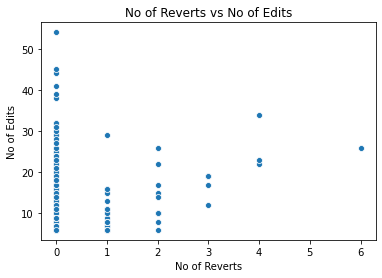

In [79]:
ax = sns.scatterplot(x="revert", y="editscount", data=proxies)
ax.set_title("No of Reverts vs No of Edits")
ax.set_xlabel("No of Reverts")
ax.set_ylabel("No of Edits")
# No of reverts are very low for highly edited items

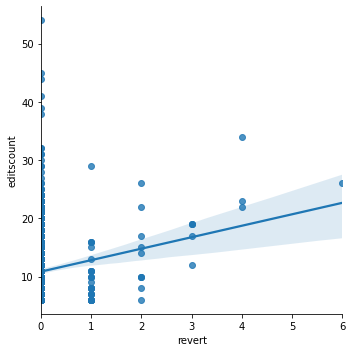

In [80]:
sns.lmplot(x="revert", y="editscount", data=proxies)

In [81]:
corr_matrix = proxies.corr()
corr_matrix
# merge and editscount have a negative correlation

,revert,merge,undo,restore,protect,remove,editscount,userscount
revert,1.000000,-0.003394,0.328781,0.317166,0.209006,0.148219,0.150006,0.427871
merge,-0.003394,1.000000,0.046213,0.183357,-0.010697,0.104730,-0.011253,0.066306
undo,0.328781,0.046213,1.000000,0.130118,0.086410,0.069023,0.155490,0.294326
restore,0.317166,0.183357,0.130118,1.000000,0.311088,0.105033,0.131760,0.173872
protect,0.209006,-0.010697,0.086410,0.311088,1.000000,0.001941,0.043685,0.106191
remove,0.148219,0.104730,0.069023,0.105033,0.001941,1.000000,0.236844,0.011402
editscount,0.150006,-0.011253,0.155490,0.131760,0.043685,0.236844,1.000000,0.076375
userscount,0.427871,0.066306,0.294326,0.173872,0.106191,0.011402,0.076375,1.000000


In [82]:
# No of users and reverts has a positive correlation
# Smaller dataset has a more precise correlation 
# Might be helpful to disregard items which have remove edits 
# but have no edits in the other proxies
# Will give us better information

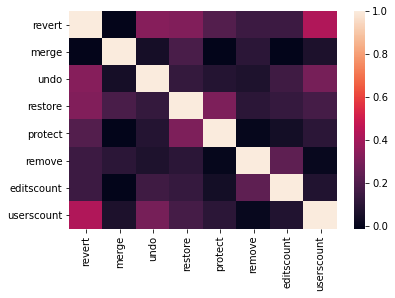

In [83]:
sns.heatmap(corr_matrix)

In [84]:
# editscount and merge
# remove and no of users

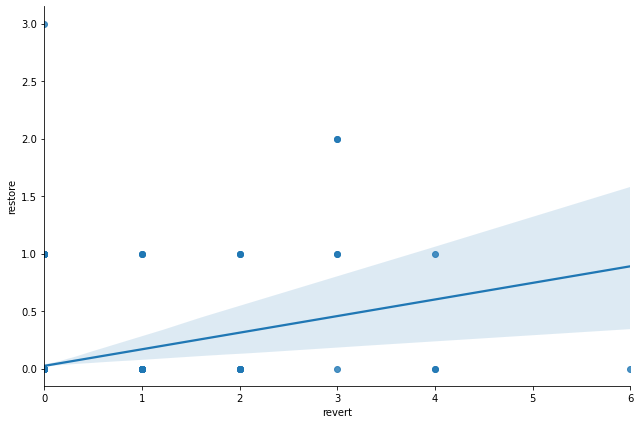

In [85]:
# restore and revert have some correlation - weak positive
sns.lmplot(x="revert", y="restore", data=proxies, height=6, aspect=1.5)

Text(0, 0.5, 'No of Edits')

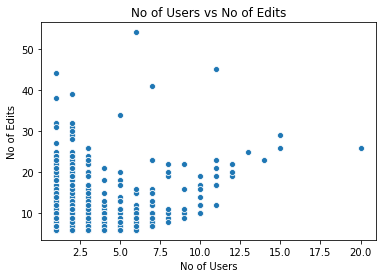

In [86]:
# userscount and editscount have a weak negative correlation - although not very high - it is much higher than others
ax = sns.scatterplot(x="userscount", y="editscount", data=proxies)
ax.set_title("No of Users vs No of Edits")
ax.set_xlabel("No of Users")
ax.set_ylabel("No of Edits")

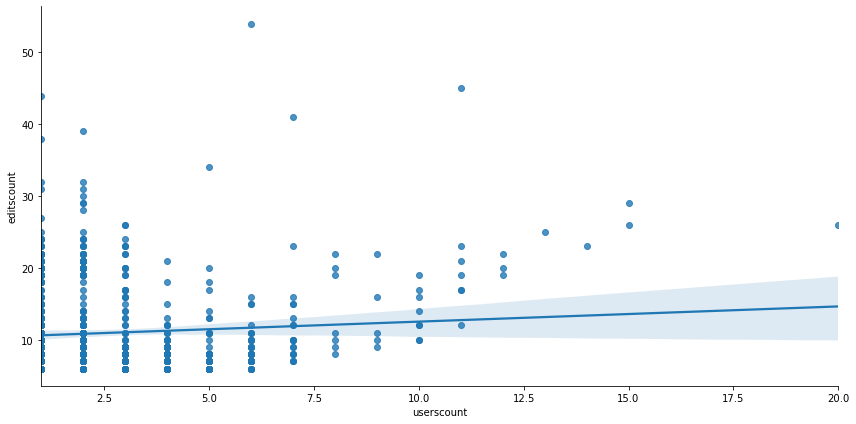

In [87]:
sns.lmplot(x="userscount", y="editscount", data=proxies, height=6, aspect=2)

In [88]:
# Removing items with 0 reverts, merges, undos, restores, removes, protects
# Removing items with editscount <= 5 
to_remove = proxies[(proxies['revert'] == 0) & (proxies['merge'] == 0) & (proxies['undo'] == 0) & (proxies['restore'] == 0) & 
                   (proxies['remove'] == 0) & (proxies['protect'] == 0)].index
proxies = proxies.drop(to_remove)

In [89]:
proxies.shape

(347, 9)

In [90]:
proxies.head()

,qid,revert,merge,undo,restore,protect,remove,editscount,userscount
3,Q2377326,0,0,0,0,0,1,7,6
7,Q2457695,1,0,0,0,0,2,11,2
8,Q2467414,1,1,0,0,0,0,7,5
9,Q2503193,0,0,0,0,0,1,6,3
10,Q2503488,0,0,0,0,0,37,38,1


In [91]:
# Notice how the last one has 37 removes out of the total no of edits
# This is why contribution analysis is important
# DO the stacked bar chart